# Calculate phase dependent modulation of AP threshold poisson excitation and rhythmic inhibition with variable frequency

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Poisson excitation at the soma and dendrites

Here we calculate voltage threshold for action potentials. These are stratified by:
1. Phase (peak or trough) of the inhibitory rhythm
2. Frequency of rhythm

The output of this script are...


In [91]:
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.load_spike_h5 import load_spike_h5
from src.load_v_h5 import load_v_h5
from src.load_axcurrent_csv import load_axcurrent_csv
from src.count_dendevt_files import count_dendevt_files
from src.bin_serser import bin_serser
from src.ser_pt import ser_pt

from scipy.signal import hilbert

## 1.0 Analysis parameters


### 1.1 Simulation constants and analysis windows

In [125]:
samps_per_ms = 10 
edges_v = np.arange(-70,-40,0.5)
edges_i = np.linspace(-3,3,160)
edges_dv = np.arange(-10,10,0.25)
sim_win = [0, 3000000] # beginning and start points of simulation in samples
step = 1 #* samps_per_ms
ph_bin_num = 8
edges = np.linspace(-np.pi, np.pi, ph_bin_num)

In [3]:
# Determines which axial currents are valid
seg_df = pd.read_csv('Z:\\DendOscSub\\DetailedSegmentsAxialR.csv')
seg_df = seg_df[['segmentID', 'Type', 'ParentSegID']]
soma_ids = seg_df[seg_df['Type']=='soma'].segmentID.values
soma_conn = seg_df[np.isin(seg_df['ParentSegID'],soma_ids)]
soma_conn = soma_conn[(soma_conn['Type']=='dend') | (soma_conn['Type']=='apic')]
soma_conn['pairname'] = soma_conn['ParentSegID'].map(lambda x: f'{x:5.0f}'.lstrip()) + '_to_' + soma_conn['segmentID'].map(str)
basal_pairs = soma_conn['pairname'][soma_conn['Type']=='dend'].values
apic_pairs = soma_conn['pairname'][soma_conn['Type']=='apic'].values

### 1.2 List files to be processed

In [ ]:
# locate simulation files
freq_list =  [0.5, 2, 5, 10, 16, 20, 30, 40, 50, 60, 80]
freq_list_str = list(map(str, freq_list))
freq_list_str[0] = 'p5'
root_dir = 'Y:\\DendCompOsc\\'
# Create sim dictionaries
sim_dicts = {}
for i in range(len(freq_list)):
    sim_name = freq_list_str[i] + 'Hzproximal_inh'
    sim_dir = root_dir + sim_name + '\\' 
    # generate phase time series for inhibitory afferents
    t_ser = np.arange(sim_win[0], sim_win[1], step) / (10000) # seconds
    sin_inh = np.sin(t_ser*freq_list[i]*2*np.pi)
    ph_inh = np.angle(hilbert(sin_inh))
    sim_dicts[freq_list_str[i]] = {'SimName': sim_name, 
                                   'RootDir': sim_dir,
                                   'CaFile': sim_dir + sim_name + '_ca.csv',
                                   'NaFile': sim_dir + sim_name + '_na.csv',
                                   'NMDAFile': sim_dir + sim_name + '_nmda.csv', 
                                   'APFile': sim_dir + 'spikes.h5',
                                   'VmFile': sim_dir + 'v_report.h5',
                                   'InhSin': sin_inh,
                                   'InhPhase': ph_inh,
                                   'Freq': freq_list[i], 
                                   'Location': 'proximal'}


root_pois_dir = 'Z:\\DendOscSub\\output_allpoisson\\'
sim_pois_dict = {'SimName': 'output_allpoisson',
               'RootDir': root_pois_dir,
               'CaFile': root_pois_dir + 'output_allpoisson_ca.csv',
               'NaFile': root_pois_dir + 'output_allpoisson_na.csv',
               'NMDAFile': root_pois_dir + 'output_allpoisson_nmda.csv',
               'APFile': root_pois_dir + 'spikes.h5',
               'VMemFile': root_pois_dir + 'v_report.h5',
               'AxCurrFile': root_pois_dir + 'axial_currents.csv'}



## 2.0 Phase binned probability of somatic spikes over membrane voltage

### 2.1 Calculate action potential threshold voltage

In [229]:
# probability of action potentials by membrane voltage
def ap_prob_func(spk, v, edges):
    null_hist = np.histogram(v, edges)
    spk_hist = np.histogram(v[spk-10], edges)
    spk_cum_prob = np.nancumsum(spk_hist[0]/null_hist[0])
    return {'null': null_hist[0], 'spk': spk_hist[0], 'prob': spk_cum_prob}

def thresh_files_func(sim_dict):
    spk_prob = {'v': {}, 'dv': {}}
    sin_ser = sim_dict['InhSin']
    # split action potentials based on phase of rhythm
    spk_t = load_spike_h5(sim_dict['APFile'])
    p_inds = np.where(sin_ser >= 0)
    t_inds = np.where(sin_ser < 0)
    spk_t_p = np.intersect1d(spk_t, p_inds)
    spk_t_t = np.intersect1d(spk_t, t_inds)
    
    # load soma voltage
    mem_v = load_v_h5(sim_dict['VmFile'], 0)
    mem_dv = np.pad(mem_v[10:]-mem_v[:-10], (10, 0), mode='edge')

    # calculate action potential probability by voltage for each phase
    spk_prob['v']['p'] = ap_prob_func(spk_t_p, mem_v, edges_v)
    spk_prob['v']['t'] = ap_prob_func(spk_t_t, mem_v, edges_v)

    # calculate action potential probability by 1 ms change in voltage for each phase
    spk_prob['dv']['p'] = ap_prob_func(spk_t_p, mem_dv, edges_dv)
    spk_prob['dv']['t'] = ap_prob_func(spk_t_t, mem_dv, edges_dv)

    # membrane voltage distribution by phase
    spk_prob['v']['p']['dist'] = np.histogram(mem_v[p_inds], edges_v)[0]
    spk_prob['v']['t']['dist'] = np.histogram(mem_v[t_inds], edges_v)[0]

    # membrane voltage mean by phase
    spk_prob['v']['p']['mean'] = np.nanmean(mem_v[p_inds])
    spk_prob['v']['t']['mean'] = np.nanmean(mem_v[t_inds])

    # change in membrane voltage distribution by phase
    spk_prob['dv']['p']['dist'] = np.histogram(mem_dv[p_inds], edges_dv)[0]
    spk_prob['dv']['t']['dist'] = np.histogram(mem_dv[t_inds], edges_dv)[0]

    # change in membrane voltage mean by phase
    spk_prob['dv']['p']['mean'] = np.nanmean(mem_dv[p_inds])
    spk_prob['dv']['t']['mean'] = np.nanmean(mem_dv[t_inds])

    # process action potential events
    spk_t = load_spike_h5(sim_dict['APFile'])
    spk_ser = ser_pt(spk_t, step, sim_win)
    spk_ser = np.array(spk_ser)/(0.001/samps_per_ms)    # multiplying by 500 converts to firing rates, 2ms bin means 1 spike per bin
    # is a firing rate of 500 Hz.
    spk_prob['ap'] = bin_serser(spk_ser.astype(float), sim_dict['InhPhase'], edges, func=np.nanmean)["values"]
    spk_prob['sin'] = bin_serser(sim_dict['InhSin'], sim_dict['InhPhase'], edges, func=np.nanmean)["values"]

    return spk_prob

def thresh_files_pois_func(sim_dict):
    spk_prob = {'v': {}}

    # split action potentials based on phase of rhythm
    spk_t = load_spike_h5(sim_dict['APFile'])
   
    # load soma voltage
    mem_v = load_v_h5(sim_dict['VMemFile'], 0)

    # calculate action potential probability by voltage
    spk_prob['v']['pois'] = ap_prob_func(spk_t, mem_v, edges_v)
   
    # membrane voltage distribution
    spk_prob['v']['pois']['dist'] = np.histogram(mem_v, edges_v)[0]

    return spk_prob

In [230]:
ph_prob = {}
for k, v in sim_dicts.items():
    print('Processing ' + k)
    ph_prob[k] = thresh_files_func(v)

# process the poisson inhibition simulation
pois_prob = thresh_files_pois_func(sim_pois_dict)

Processing p5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 2


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 5


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 10


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 16


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 20


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 30


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 40


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 50


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 60


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


Processing 80


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\bin_serser.py:60: RuntimeWarning: Mean of empty slice
  bin_temp.append(func(val_ser[bin_inds == curr_ind]))


### 2.2 Plots

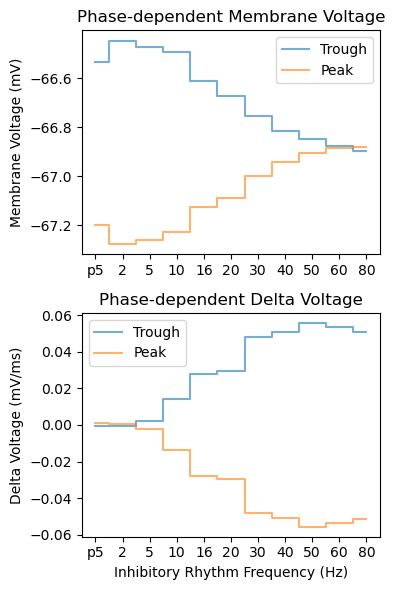

In [235]:
mv_mean_t = np.array([ph_prob[freq]['v']['t']['mean'] for freq in freq_list_str])
mv_mean_p = np.array([ph_prob[freq]['v']['p']['mean'] for freq in freq_list_str])
dv_mean_t = np.array([ph_prob[freq]['dv']['t']['mean'] for freq in freq_list_str])
dv_mean_p = np.array([ph_prob[freq]['dv']['p']['mean'] for freq in freq_list_str])

fig, ax = plt.subplots(2,1, figsize=(4, 6))
ax[0].step(freq_list_str, mv_mean_t, where='mid', label='Trough', alpha=0.6)
ax[0].step(freq_list_str, mv_mean_p, where='mid', label='Peak', alpha=0.6)
ax[1].step(freq_list_str, dv_mean_t, where='mid', label='Trough', alpha=0.6)
ax[1].step(freq_list_str, dv_mean_p, where='mid', label='Peak', alpha=0.6)
ax[0].set_ylabel('Membrane Voltage (mV)')
ax[1].set_ylabel('Delta Voltage (mV/ms)')
ax[1].set_xlabel('Inhibitory Rhythm Frequency (Hz)')
ax[0].set_title('Phase-dependent Membrane Voltage')
ax[1].set_title('Phase-dependent Delta Voltage')
ax[0].legend()
ax[1].legend()
fig.tight_layout()

fig.savefig('../figures/MembraneVoltAndDvMeanVarFreq.pdf')